# M7_AI3_Generación de texto
#### Autor: Leandro Gutierrez
#### Este documento intenta dar respuesta a la actividad individual 4 propuesta en el Modulo **Técnicas Avanzadas de Machine Learning**. En él se describirán cada uno de los enunciados postulados y los resultados obtenidos.
#### Enero 11, 2025

# Generación de texto con una red LSTM
En esta actividad vamos a utilizar una red recurrente LSTM para generar texto.

El corpus que sirve de referencia para generar los textos consiste en Alicia en el País de las Maravillas, aunque se puede utilizar cualquier otro.

El interés de esta actividad es utilizar las redes **LSTM para algo distinto de una clasificación**, aunque, como se puede observar, la calidad de los textos generados es inferior a la que se consigue con otros modelos más actuales, como los transformer.

**Debes completar el código en las secciones indicadas con # COMPLETAR CODIGO**

## Instalación e importación de paquetes

In [1]:
!pip install progressbar2


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import urllib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import html

import nltk
from nltk import word_tokenize
nltk.download('punkt')
import pickle
import random
import progressbar
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

try:
    from nltk.tokenize.moses import MosesDetokenizer
    detokenizer = MosesDetokenizer()
    use_moses_detokenizer = True
except:
    use_moses_detokenizer = False

print(f"use_moses_detokenizer={use_moses_detokenizer}")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lgutierrez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


use_moses_detokenizer=False


## Definición de parámetros del corpus y su preprocesado

In [3]:
corpus_url = "https://www.gutenberg.org/cache/epub/11/pg11.txt"
corpus_path = "alicia.txt"
preprocessed_corpus_path = "alicia_preprocessed.p"
most_common_words_number = 10000


## Tranformación entre palabras e índices
Se definen dos funciones:
* **encode_sequence**: codifica una secuencia de palabras en una secuencia de índices
* **decode_indices**: decodifica una secuencia de índices en la secuencia de palabras correspondiente

In [4]:
def encode_sequence(sequence, vocabulary):

    return [vocabulary.index(element) for element in sequence if element in vocabulary]


def decode_indices(indices, vocabulary):

    decoded_tokens = [vocabulary[index] for index in indices]
    if use_moses_detokenizer  == True:
        return detokenizer.detokenize(decoded_tokens, return_str=True)
    else:
        return " ".join(decoded_tokens)

## Descarga del corpus
Solo se descarga si no se encuentra en local (Colab o disco)

In [5]:
import requests

def download_corpus_if_necessary():

    if not os.path.exists(corpus_path):
        print("Descargamos el corpus...")

        # Descargamos el contenido
        corpus_string = requests.get(corpus_url).content.decode('utf-8')

        print(corpus_string)
        # Eliminamos etiquetas HTML
        corpus_string = corpus_string.replace("<pre>", "")
        corpus_string = corpus_string.replace("</pre>", "")


        # Grabamos en fichero
        corpus_file = open(corpus_path, "w")
        corpus_file.write(corpus_string)
        corpus_file.close()

        print("El corpus se ha grabado en", corpus_path)
    else:
        print("El corpus ya estaba grabado")

download_corpus_if_necessary()

El corpus ya estaba grabado


## Preprocesado del corpus
Solo se preprocesa si no se ha hecho antes.

In [37]:
def preprocess_corpus_if_necessary():

    if not os.path.exists(preprocessed_corpus_path):
        print("Preprocesamos el corpus...")

        corpus_file = open(corpus_path, "r")
        corpus_string = corpus_file.read()

        # Generación del vocabulario
        print("Extraemos las palabras (tokens)...")
        corpus_tokens = word_tokenize(corpus_string)
        print(corpus_tokens[:10])
        print("Número de tokens:", len(corpus_tokens))
        print("Generamos el vocabulario...")
        word_counter = Counter()
        word_counter.update(corpus_tokens)
        print("Longitud del vocabulario antes del corte:", len(word_counter))
        vocabulary = [key for key, value in word_counter.most_common(most_common_words_number)]
        print("Longitud del vocabulario después del corte:", len(vocabulary))

        # Conversión a índices
        print("Codificamos a índices...")
        indices = encode_sequence(corpus_tokens, vocabulary)
        print("Número de índices:", len(indices))

        # Saving.
        print("Grabamos fichero de preprocesado del corpus...")
        pickle.dump((indices, vocabulary), open(preprocessed_corpus_path, "wb"))
    else:
        print("El corpus ya estaba preprocesado")

preprocess_corpus_if_necessary()

Preprocesamos el corpus...
Extraemos las palabras (tokens)...
['\ufeffThe', 'Project', 'Gutenberg', 'eBook', 'of', 'Alice', "'s", 'Adventures', 'in', 'Wonderland']
Número de tokens: 38046
Generamos el vocabulario...
Longitud del vocabulario antes del corte: 3873
Longitud del vocabulario después del corte: 3873
Codificamos a índices...
Número de índices: 38046
Grabamos fichero de preprocesado del corpus...


## Generación del dataset
Enfocamos la generación del dataset como un **aprendizaje auto-supervisado (self-supervised learning)**:
* para generar secuencias de entrada, seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras) del corpus
* para asignar una etiqueta, escogemos el índice de la palabra siguiente a la secuencia de entrada

In [7]:
# Parámetros de generación del dataset
dataset_size = 50000
sequence_length = 30 # longitud de los textos del dataset de entrenamiento

def get_dataset(indices):

    data_input = []
    data_output = []
    current_size = 0
    bar = progressbar.ProgressBar(max_value=dataset_size)
    while current_size < dataset_size:

        # seleccionamos de forma aleatoria una secuencia de índices (correspondientes a palabras)
        random_index = random.randint(0, len(indices) - (sequence_length + 1))
        input_sequence = indices[random_index:random_index + sequence_length]
        # la etiqueta de la secuencia aleatoria es el índice de la siguiente palabra
        output_label = indices[random_index + sequence_length]

        data_input.append(input_sequence)
        data_output.append(output_label)

        current_size += 1
        bar.update(current_size)
    bar.finish()

    # Transformamos las listas a numpy arrays
    data_input = np.array(data_input)
    data_output = np.array(data_output)
    return (data_input, data_output)


In [35]:
indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))
data_input, data_output = get_dataset(indices)
data_output = to_categorical(data_output, num_classes=len(vocabulary))
print(indices)
print(vocabulary)
# len(data_output[:10])
# data_output[:1].shape

  0% (0 of 50000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
 44% (22152 of 50000) |#######           | Elapsed Time: 0:00:00 ETA:   0:00:00
 81% (40507 of 50000) |##############    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00


[1889, 53, 175, 441, 9, 16, 1308, 683, 15, 684, 233, 1309, 44, 33, 1, 183, 9, 685, 993, 15, 1, 280, 281, 5, 341, 100, 994, 9, 1, 442, 25, 63, 817, 5, 23, 483, 63, 1310, 1311, 4, 83, 195, 342, 10, 0, 343, 10, 184, 36, 1312, 10, 223, 1, 224, 9, 1, 53, 175, 401, 995, 23, 35, 1309, 36, 818, 25, 686, 4, 151, 17, 75, 34, 543, 15, 1, 280, 281, 0, 17, 165, 60, 6, 819, 1, 402, 9, 1, 687, 344, 17, 75, 543, 142, 484, 35, 441, 4, 1890, 21, 16, 1308, 683, 15, 684, 1891, 21, 1313, 1314, 1892, 996, 21, 1893, 1894, 0, 1895, 820, 441, 1896, 1897, 821, 1315, 1898, 1899, 21, 1900, 1901, 0, 1902, 1903, 21, 544, 1904, 21, 1905, 1906, 5, 1907, 1908, 70, 70, 70, 1316, 373, 443, 822, 997, 1317, 1318, 1319, 1320, 998, 1321, 70, 70, 70, 820, 1909, 821, 16, 7, 27, 683, 15, 684, 61, 1313, 1314, 443, 1910, 1911, 1912, 1913, 1914, 206, 11, 4, 823, 1, 1322, 206, 1323, 4, 41, 1324, 9, 1325, 206, 1326, 4, 253, 1327, 5, 8, 1328, 1329, 206, 1330, 4, 41, 120, 1331, 15, 8, 1332, 282, 206, 1333, 1334, 105, 8, 176, 206, 133

In [38]:
type(data_input)

numpy.ndarray

In [30]:
len(vocabulary)

3873

## Definición de la red LSTM y entrenamiento
Solo se define y entrena si no se ha hecho antes, o si se fuerza con el parámetro train_anyway.

Por último, se graba el modelo.

  0% (0 of 50000) |                      | Elapsed Time: 0:00:00 ETA:  --:--:--
 54% (27216 of 50000) |#########         | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (50000 of 50000) |##################| Elapsed Time: 0:00:00 Time:  0:00:00



Generamos el dataset...
Creamos el modelo...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo...
Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 58ms/step - categorical_accuracy: 0.0834 - loss: 6.1631
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - categorical_accuracy: 0.1958 - loss: 4.7975
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - categorical_accuracy: 0.2466 - loss: 4.1295
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 58ms/step - categorical_accuracy: 0.2877 - loss: 3.6010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - categorical_accuracy: 0.3419 - loss: 3.1685
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - categorical_accuracy: 0.4044 - loss: 2.7636
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - categorical_accuracy: 0.4651 - loss: 2.4226
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - categorical_accuracy: 0.5195 - loss: 2.1468
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - categorical_accuracy: 0.5665 - loss: 1.9226
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 60ms/step - categorical_accurac

...y grabamos el modelo
dict_keys(['categorical_accuracy', 'loss'])


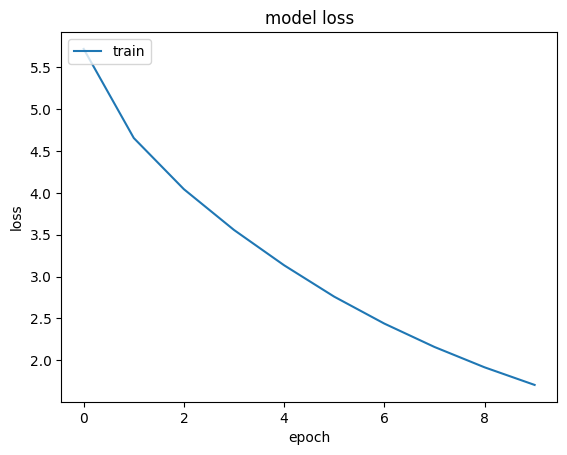

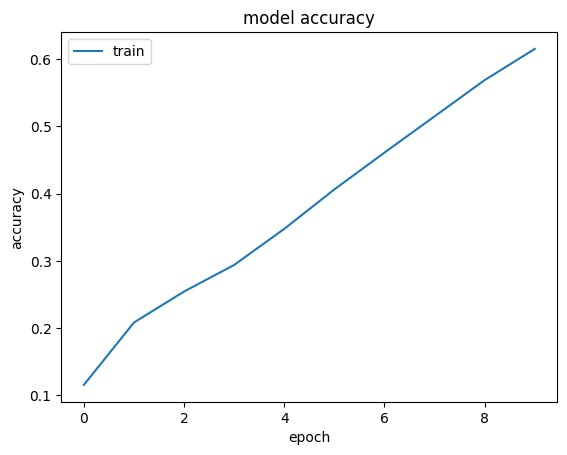

In [33]:
import tensorflow as tf

# Parámetros del modelo y entrenamiento
train_anyway = True # fuerza el entrenamiento, aunque se haya realizado antes
epochs = 10 # número de interaciones a entrenar
batch_size = 128 # tamaño de lote
hidden_size = 1000 # número de nodos en la red LSTM
model_path = "alicia_model.h5"

def train_neural_network():

    if not os.path.exists(model_path) or train_anyway == True:

        # Carga de las palabras del corpus y sus índices
        indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

        # Generación del dataset
        print("\nGeneramos el dataset...")
        data_input, data_output = get_dataset(indices)
        data_output = to_categorical(data_output, num_classes=len(vocabulary))

        # Creación del modelo
        print("Creamos el modelo...")
        
        # config inicial
        vocab_size = len(vocabulary)
        embedding_size = 100
        lstm_units = 256

        model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=None, name="embedding"),
            tf.keras.layers.LSTM(lstm_units, return_sequences=False, name="lstm"),
            tf.keras.layers.Dense(vocab_size, activation='softmax', name="output")
        ])

        # Definimos el resto del modelo: optimizador, función de pérdidas y métrica
        model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy']
        )

        model.summary()

        # Entrenamiento del modelo
        print("Entrenamos el modelo...")
        history = model.fit(data_input, data_output, epochs=epochs, batch_size=64)
        print(history)
        # Grabación del modelo
        print("...y grabamos el modelo")
        model.save(model_path)

        plot_history(history)
        

def plot_history(history):

    print(history.history.keys())

    # Gráfica de función de pérdida
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("history_loss.png")
    # plt.clf()
    plt.show()
    plt.close()
    
    # Gráfica de accuracy.
    plt.plot(history.history['categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig("history_accuracy.png")
    # plt.clf()

    plt.show()
    plt.close()
        
train_neural_network()

## Generación de texto

La generación de texto se basa en la función **get_index_from_prediction**, que obtiene un índice a partir de una predicción y un parámetro de temperatura 

In [ ]:
# Parámetros de generación de texto
generated_sequence_length = 50 # longitud de los textos generados
n_generated_texts = 15 # número de textos a generar

def generate_texts(n_generated_texts=10):

    print(f"Generamos {n_generated_texts} textos...")

    # carga del corpus
    indices, vocabulary = pickle.load(open(preprocessed_corpus_path, "rb"))

    # carga del modelo previamente grabado
    model = models.load_model(model_path)

    # Generamos tantos textos como indique el parámetro n_generated_texts
    for _ in range(n_generated_texts):

        # Escogemos un parámetro aleatorio "temperature" para la predicción
        temperature = random.uniform(0.0, 1.0)
        print("Temperatura:", temperature)

        # Obtenemos una muestra aleatoria a modo de secuencia semilla a partir de la cual se generarán textos
        random_index = random.randint(0, len(indices) - (generated_sequence_length))
        input_sequence = indices[random_index:random_index + sequence_length]

        # Generamos la secuenca de salida repitiendo la predicción
        generated_sequence = []
        while len(generated_sequence) < generated_sequence_length:
            prediction = model.predict(np.expand_dims(input_sequence, axis=0))
            predicted_index = get_index_from_prediction(prediction[0], temperature)
            generated_sequence.append(predicted_index)
            input_sequence = input_sequence[1:]
            input_sequence.append(predicted_index)

        # Convertimos la secuencia de índices generada en una frase
        text = decode_indices(generated_sequence, vocabulary)
        print(text)
        print("")

        
def get_index_from_prediction(prediction, temperature=0.0):

    # Temperatura cero - usamos argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Temperatura distinta de cero - aplicamos cierta aleatoriedad
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate_texts(n_generated_texts)